In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Model Testing

In [2]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import r2_score

### Read in Data from Google Drive

In [28]:
df = pd.read_csv("/content/drive/My Drive/data/countyMLDataV1.2.csv").drop(["Unnamed: 0"], axis=1).dropna(axis=0).reset_index().drop('index',axis=1)
counties = []
for c in df.FIPS:
  counties.append(str(c).zfill(5))
df = df.drop("FIPS", axis=1)

In [34]:
scaler = StandardScaler()

In [106]:
X = df.drop('Total Solar Capacity MW-AC', axis=1)
y = df['Total Solar Capacity MW-AC']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Random Forest Regressor for Solar Capacity MW-AC



In [107]:
rf = RandomForestRegressor(n_estimators=25, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X)
r2_score(y, rf_pred)

0.7973994114221836

### SVM Using same Train and Test Data


In [108]:
from sklearn import svm
svc = svm.SVR()
svc.fit(X_train, y_train)
svc_pred = svc.predict(X)
r2_score(y, svc_pred)

-0.01912342210415008

### Gradient Boost

In [109]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)
gbr_pred = gbr.predict(X)
r2_score(y, gbr_pred)

0.88127282779228

### Decision Tree

In [110]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=42)
dtr.fit(X_train, y_train)
dtr_pred = dtr.predict(X)
r2_score(y, dtr_pred)

0.7355140629880502

### The Big Finale; Ensemble Testing

In [111]:
test_results = pd.DataFrame({"Counties":counties, "Random Forest":rf_pred, "SVM":svc_pred, "Gradient Boost":gbr_pred, "Decision Tree":dtr_pred})

avg = []
dif  = []
percent_dif = []
for ind, row in test_results.iterrows():
  avg.append((test_results["Random Forest"][ind] + test_results["SVM"][ind] + test_results["Gradient Boost"][ind] + test_results["Decision Tree"][ind])/4)
  dif.append(avg[ind] - y[ind])
  percent_dif.append(dif[ind]/X['Land coverage(sq miles)'][ind])
r2_score(y, avg)

0.8175692124597038

### Combining Computed Scores to final DataFrame

In [112]:
averagedf = pd.DataFrame({"Counties":counties, "True":y, "Average Score":avg, "Difference from True":dif, "Difference Scaled to Land Size":percent_dif})
final_results = test_results.merge(averagedf, how="left", on="Counties")
final_results.to_csv("/content/drive/My Drive/data/test_results.csv")

### Highest County Discrepancy (Not adjusted for County Size)

In [120]:
fips2county = pd.read_csv("/content/drive/My Drive/data/fips2county.tsv", delimiter="\t")
counties = []
for c in fips2county.CountyFIPS:
  counties.append(str(c).zfill(5))
f2cdf = pd.DataFrame({"Counties":counties, "County Name":fips2county.CountyName, "State":fips2county.StateName})

In [121]:
topCounties = final_results.merge(f2cdf, how="left", on="Counties")
topCounties.sort_values(by=['Difference from True'], ascending=False).head(15)


,Counties,Random Forest,SVM,Gradient Boost,Decision Tree,True,Average Score,Difference from True,Difference Scaled to Land Size,County Name,State
191,06071,1948.6924,1.023754,1350.408059,3021.00,605.5,1580.281053,974.781053,0.048601,San Bernardino,California
1778,35035,209.4712,0.720573,122.992851,1563.46,22.5,474.161156,451.661156,0.068297,Otero,New Mexico
169,06027,1243.2764,4.465530,47.731342,0.00,0.0,323.868318,323.868318,0.031811,Inyo,California
1771,35023,208.3984,0.295381,163.467169,440.00,0.0,203.040237,203.040237,0.059077,Hidalgo,New Mexico
309,12043,160.1728,0.103294,183.100731,149.00,0.0,123.094206,123.094206,0.152720,Glades,Florida
2810,51057,51.8400,0.099612,10.132183,500.00,20.0,140.517949,120.517949,0.468723,Essex,Virginia
74,04015,192.0668,1.376012,215.273866,325.10,65.0,183.454170,118.454170,0.008899,Mohave,Arizona
72,04012,457.5428,0.475667,102.440811,32.50,32.5,148.239819,115.739819,0.025722,La Paz,Arizona
70,04009,48.7992,0.463246,24.809638,375.00,0.0,112.268021,112.268021,0.024287,Graham,Arizona
315,12055,235.9128,0.103162,162.575753,223.50,45.0,155.522929,110.522929,0.108716,Highlands,Florida


### Number of Counties Over-Estimated by a Value of 5 MW-AC
This value is specifically chosen because that amount, if generated, qualifies as a Utility-Scale solar plant

In [122]:
len(final_results[final_results['Difference from True'] > 5])

398

In [ ]:
phoenix_ghi_ts = pd.read_csv('/content/drive/My Drive/data/323705_33.45_-112.06_tmy-2021.csv', skiprows=2)
print(phoenix_ghi_ts['Year'].unique())


phoenix_ghi_ts.head()

[2010 2001 2013 2015 2018 2002 2006 2008 2004]


,Year,Month,Day,Hour,Minute,GHI,Temperature
0,2010,1,1,0,30,0,3.9
1,2010,1,1,1,30,0,3.8
2,2010,1,1,2,30,0,3.9
3,2010,1,1,3,30,0,3.9
4,2010,1,1,4,30,0,3.8


In [ ]:
df_cleaned = phoenix_ghi_ts.drop(index=[0, 1]).reset_index(drop=True)

df_cleaned.columns = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'GHI', 'Temperature']

df_cleaned['Datetime'] = pd.to_datetime(df_cleaned[['Year', 'Month', 'Day', 'Hour', 'Minute']])

df_cleaned['GHI'] = pd.to_numeric(df_cleaned['GHI'], errors='coerce')

df_cleaned = df_cleaned.dropna(subset=['GHI'])

df_daily_ghi = df_cleaned.groupby(df_cleaned['Datetime'].dt.date)['GHI'].mean().reset_index()
df_daily_ghi['Datetime'] = pd.to_datetime(df_daily_ghi['Datetime'])

df_daily_ghi.head()

,Datetime,GHI
0,2001-02-01,190.583333
1,2001-02-02,186.375000
2,2001-02-03,175.333333
3,2001-02-04,190.791667
4,2001-02-05,193.208333


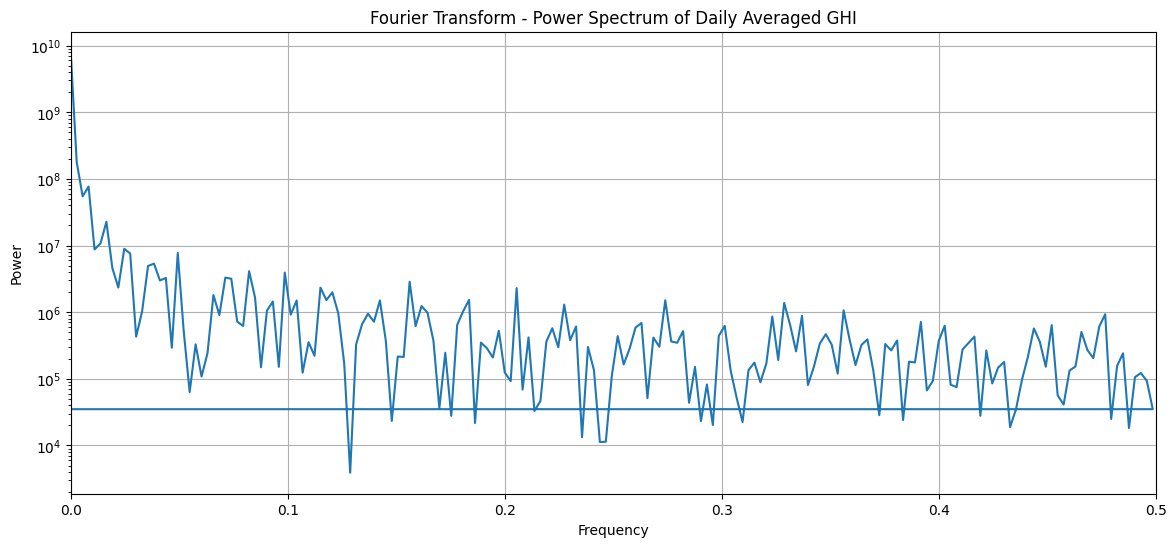

In [ ]:
import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt

ghi_fft = fft(df_daily_ghi['GHI'].values)

power_spectrum = np.abs(ghi_fft)**2

freq = np.fft.fftfreq(df_daily_ghi['GHI'].size, d=1)

plt.figure(figsize=(14, 6))
plt.plot(freq, power_spectrum)
plt.title('Fourier Transform - Power Spectrum of Daily Averaged GHI')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.yscale('log')
plt.grid(True)
plt.xlim(0, 0.5)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df_daily_ghi['GHI'])

adf_output = {
    'Test Statistic': adf_result[0],
    'p-value': adf_result[1],
    'Number of Lags Used': adf_result[2],
    'Number of Observations Used': adf_result[3],
    'Critical Values': adf_result[4],
}

adf_output

{'Test Statistic': -2.435701578693906,
 'p-value': 0.13191234463069257,
 'Number of Lags Used': 5,
 'Number of Observations Used': 359,
 'Critical Values': {'1%': -3.4486972813047574,
  '5%': -2.8696246923288418,
  '10%': -2.571077032068342}}

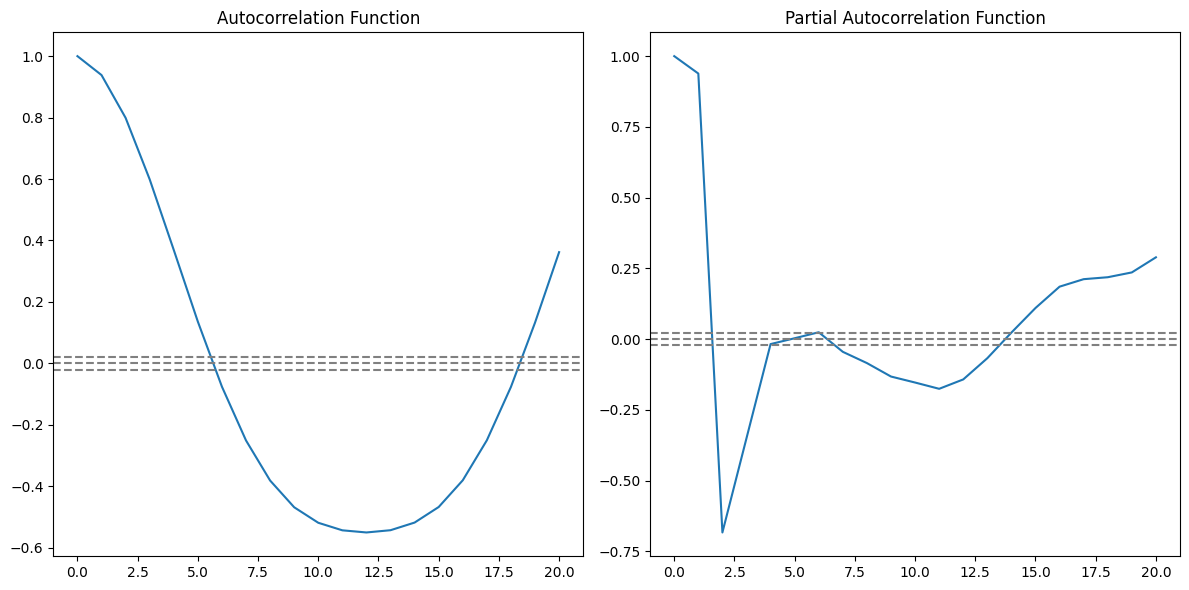

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
import numpy as np
import matplotlib.pyplot as plt



ghi_series_corrected = phoenix_ghi_ts['GHI']

lag_acf = acf(ghi_series_corrected, nlags=20)
lag_pacf = pacf(ghi_series_corrected, nlags=20, method='ols')

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ghi_series_corrected)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ghi_series_corrected)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ghi_series_corrected)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ghi_series_corrected)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()


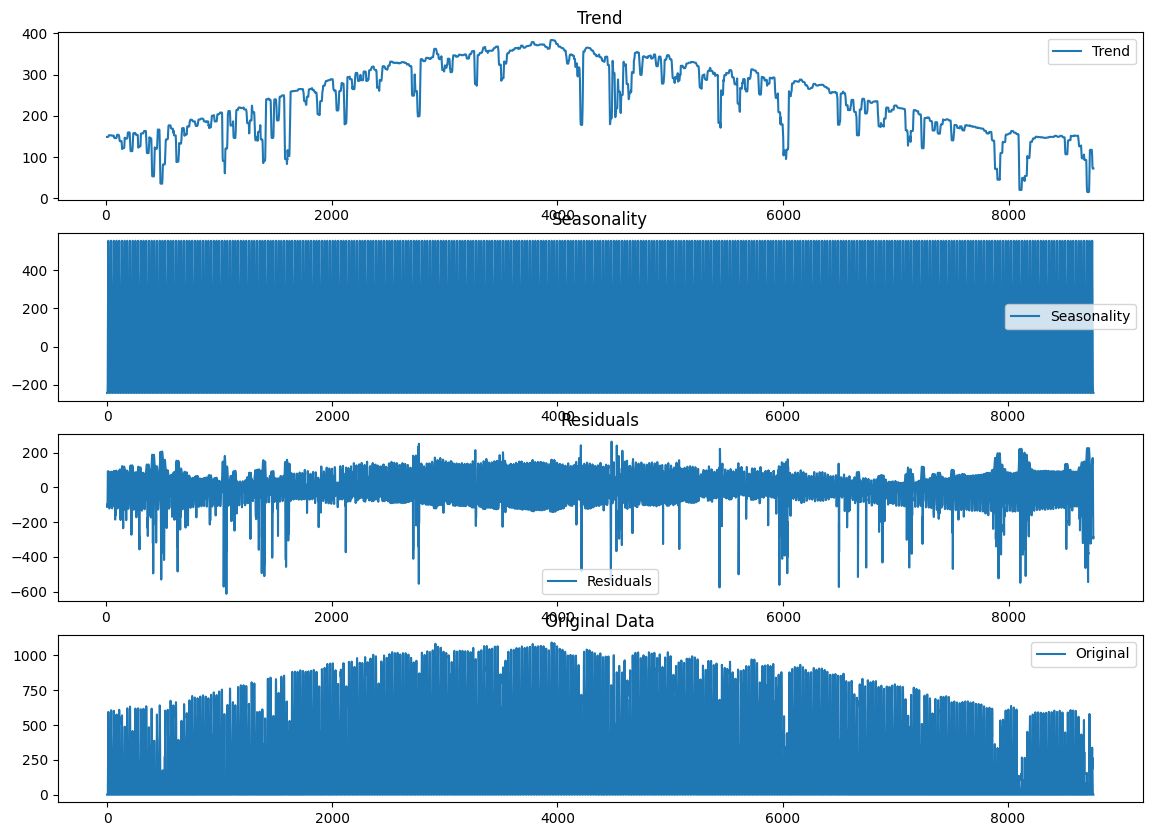

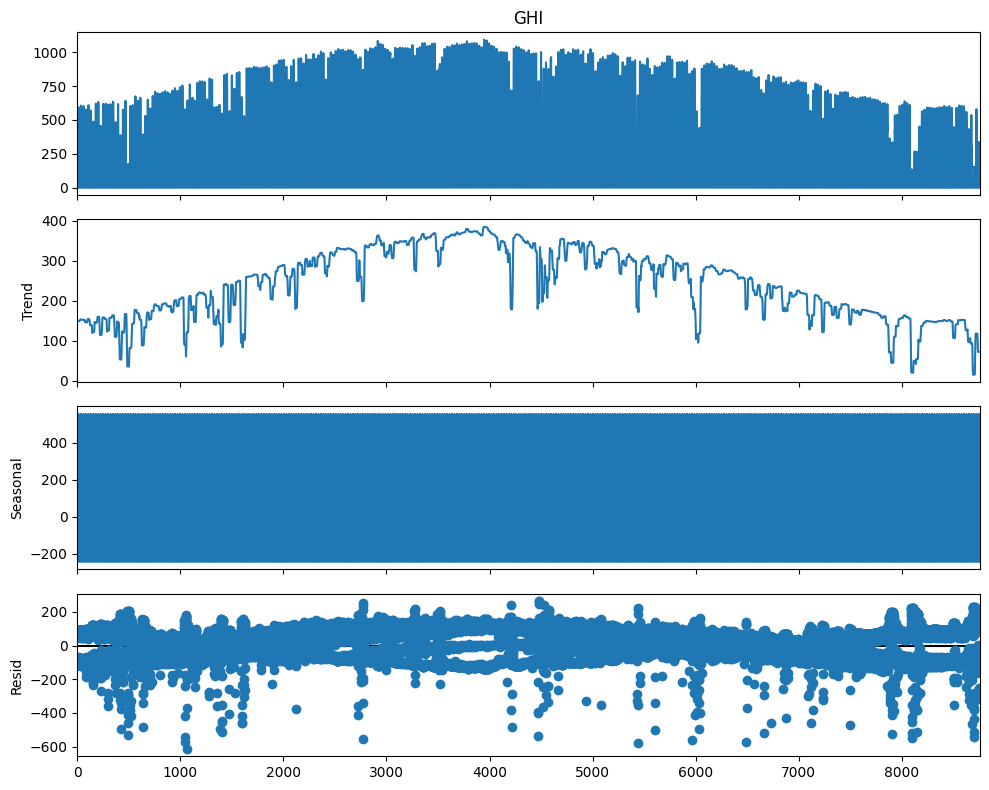

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
ghi_series_sorted = ghi_series_corrected.sort_index()

decomposition_sorted = seasonal_decompose(ghi_series_sorted, model='additive', period=24)

trend = decomposition_sorted.trend
seasonal = decomposition_sorted.seasonal
residual = decomposition_sorted.resid

plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.title('Trend')
plt.subplot(412)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.title('Seasonality')
plt.subplot(413)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.title('Residuals')
plt.subplot(414)
plt.plot(ghi_series_sorted, label='Original')
plt.legend(loc='best')
plt.title('Original Data')

fig_sorted = decomposition_sorted.plot()
fig_sorted.set_size_inches(10, 8)
plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

data_diff = df_daily_ghi.diff().dropna()

adf_test = adfuller(data_diff['GHI'])

adf_results = pd.DataFrame({
    'ADF Test Statistic': adf_test[0],
    'p-value': adf_test[1],
    'Lags Used': adf_test[2],
    'Number of Observations': adf_test[3],
    'Critical Values': adf_test[4],
}, index=['Value'])

adf_results.head()

,ADF Test Statistic,p-value,Lags Used,Number of Observations,Critical Values
Value,-11.853913,7.101698e-22,4,359,NaN


TypeError: float() argument must be a string or a real number, not 'Timedelta'

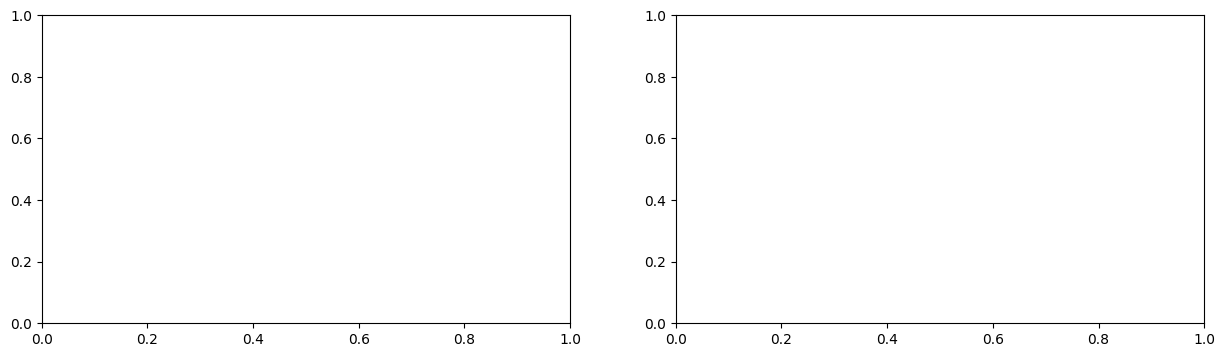

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(15, 4))

plot_acf(data_diff, ax=axes[0], lags=40)

plot_pacf(data_diff, ax=axes[1], lags=40)

plt.tight_layout()
plt.show()